**Fin 585R**  
**Diether**  
**Regression/Estimating Linear Models** 

**Overview**

The purpose of this notebook is to introduce how to estimate linear regressions using the Python Data Analysis library. In this class, we will primarily rely on the `statsmodels` library to estimate regression models.

To introduce estimating regression models using Pandas/statsmodels I am going to use the short-selling data we used in your first portfolio assignment. Remember, the data are monthly stock data for all stocks in the U.S. with non-missing loan fee data. The basic unit of observation is the stock month. You can download the data directly using the following link: [the data](http://diether.org/prephd/03-mstk_short_02-12.csv). The data contain the following variables:

|Variable | Description                                       |
|---------|---------------------------------------------------|
|permno   | stock identifier                                  |
|caldt    | calendar date                                     |
|ret      | monthly return                                    |
|prclag   | stock price, lagged                               |   
|melag    | market equity, lagged                             |
|feelag   | the loan fee expressed a percent per anum, lagged |

Remember, feelag represent the cost of shorting.

You should look over this notebook on you own. If you have questions please bring them up in class.

**I. Importing the statsmodel library**

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

**II. Read in the data and create a `dataframe`**

I am going to read in the data, multiple returns by 100 (so they represent percent per month), and create the port/binning variable from the homework using a different method. 

In [2]:
df = pd.read_csv("https://diether.org/prephd/03-mstk_short_02-12.csv",parse_dates=['caldt'])
df['ret'] = df['ret']*100

df['port'] = 'low'
df.loc[(df.feelag >= 3) & (df.feelag < 5),'port'] = 'medium'
df.loc[df.feelag >= 5,'port'] = 'high'
df.head()

,permno,caldt,ret,prclag,melag,feelag,port
0,10001,2005-06-30,12.8430,8.02,21.053,0.15000,low
1,10001,2005-07-29,0.9945,9.05,26.363,0.32701,low
2,10001,2005-08-31,3.9387,9.14,26.625,0.15000,low
3,10001,2005-10-31,-11.9040,11.51,33.529,0.16250,low
4,10001,2005-11-30,-5.9397,10.10,29.421,0.15000,low


**Estimating Regressions**

Estimating linear models using regressions will be a bread and butter part of the course as we move forward. `Statsmodels` is our main regression analysis library in Python. It has a formula based interface with a syntax very similar to R. It's designed to work seamlessly with `pandas`' dataframes.

**Estimating regressions using statsmodels and the patsy formula interface**

First, let's do a simple pooled univariate linear regression using `ret` and `feelag`. So the model is the following:<br>

$$
ret_{it} = a + \beta fee_{i,t-1} + \epsilon_{it}
$$

Graphically, we are fitting a line through the following scatterplot:

<AxesSubplot:xlabel='feelag', ylabel='ret'>

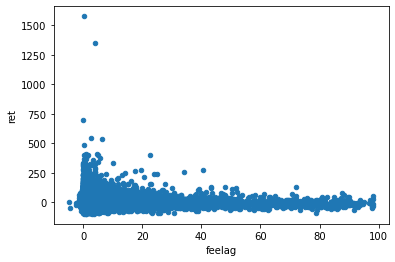

In [3]:
df.plot.scatter(y='ret',x='feelag')

Statsmodels include an ols function. The ols function requires two parameters (and you can use other optional parameters). The **first required parameter is a formula expressed as a string.** This formula interface may seem slightly strange the first time you see it, but it allows you to compactly express linear models. What does the formula string look like for the following regression?

$$
ret_{it} = a + \beta fee_{i,t-1} + \epsilon_{it}
$$

The formula string is the following:

```python
'ret ~ feelag'
```

A few notes on the formula interface:

1. `~` is the equal sign in the formula interface. I think the idea behind the use of `~` is the `=` is used in so many other contexts for a programming languge. The use of `~` makes it obvious that we are writing formula for a model.<br><br>

2. Model coefficients are implied. If we want to estimate the following regression we don't need to specify the $\alpha$ and the $\beta$ in our statsmodel formula (technically it's called a patsy formula ... that's the name of the formula library): <BR><br>
$$
ret_{it} = a + \beta fee_{i,t-1} + \epsilon_{it}
$$ <br>
The formula assumes it because an intercept and a slope coefficient are standard part of a univariate linear model.<br><br>

3. This formula syntax comes from the R statistical programming language (well, really it comes from the S statistical language ... R started off as basically a reimplementation of that language).

The **second required parameter is the dataframe** containing the data that will be used; the dataframe must contain both the dependent and indepent variables (with the exception that you can create new variables derived from the variables in the dataframe via the formula interface).<br><br>

In [4]:
reg0 = smf.ols('ret ~ feelag',data=df).fit()

Note, the above function call to `smf.ols` and the `fit()` method estimates the regression and then creates a regression object. If I print out reg0, then I get the following:

In [5]:
reg0

**Statsmodels Regression Object**

It's just an object, and by default it doesn't report the results when we print it. A statsmodel regression object contains a lot of methods that allow you to access or report information from the regression but you have to call them explicitly.< We will probably use the `summary` method the most. The summary method outputs the results of the regression:

In [6]:
reg0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     710.4
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          2.18e-156
Time:                        14:03:24   Log-Likelihood:            -1.8562e+06
No. Observations:              437775   AIC:                         3.712e+06
Df Residuals:                  437773   BIC:                         3.712e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0865      0.026     41.358      0.000       1.035       1.138
feelag        -0.1833      0.007    -26.653      0.000      -0.197      -0.170
==============================================================================
Omnibus:                   558850.871   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1874374539.071
Skew:                           6.014   Prob(JB):                         0.00
Kurtosis:                     323.334   Cond. No.                         3.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br>

**Creating new variables via the formula interface**

You can create new variables derived from the variables in the dataframe via the formula interface. For example, maybe you want to include lagged market-cap (`melag`) as a control variable but you also know that market-cap is pretty skewed (some stocks have very big market-caps). Therefore, you want to take the natural log of the variable. You don't need to create a new column with the natural log of `melag` in your dataframe. Instead, you can create it in the formula string itself. So let's estimate the following regression and create the independent variable we need in the formula string:

$$
ret_{it} = a + \beta_1 fee_{i,t-1} + \beta_2 log(me_{i,t-1}) +  \epsilon_{it}
$$

In [7]:
reg1 = smf.ols('ret ~ feelag + np.log(melag)',data=df).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     479.3
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          1.22e-208
Time:                        14:03:27   Log-Likelihood:            -1.8561e+06
No. Observations:              437775   AIC:                         3.712e+06
Df Residuals:                  437772   BIC:                         3.712e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.4116      0.088     27.346      0.000       2.239       2.584
feelag           -0.2045      0.007    -29.189      0.000      -0.218      -0.191
np.log(melag)    -0.2113      0.013    -15.739      0.000      -0.238      -0.185
==============================================================================
Omnibus:                   556869.765   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1866354700.183
Skew:                           5.970   Prob(JB):                         0.00
Kurtosis:                     322.650   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Creating dummy variables and interaction terms via the formula interface**

One nice feature of the formula interface is it includes a special function for creating dummy variables/categorial variables. The function is called `C` (\leftarrow$ short for Categorical). In the homework you created a `port` variable that breaks feelag into low, median, and high categories. I recreated that variable at the beginning of the notebook. Let's create a model that uses those categories as dummy variables instead of using feelag<br>

$$
ret_{it} = a + \beta_1\bigl(3 < fee_{i,t-1} <= 5\bigr) + \beta_2\bigl(fee_{i,t-1} > 5\bigr) +  \beta_3 log(me_{i,t-1}) + \epsilon_{i}
$$

<br>

In [8]:
reg2 = smf.ols('ret ~ C(port) + np.log(melag)',data=df).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     434.3
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          9.76e-282
Time:                        14:03:30   Log-Likelihood:            -1.8559e+06
No. Observations:              437775   AIC:                         3.712e+06
Df Residuals:                  437771   BIC:                         3.712e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.0789      0.133     -8.108      0.000      -1.340      -0.818
C(port)[T.low]        3.8169      0.123     30.908      0.000       3.575       4.059
C(port)[T.medium]     1.2931      0.181      7.146      0.000       0.938       1.648
np.log(melag)        -0.2543      0.014    -18.658      0.000      -0.281      -0.228
==============================================================================
Omnibus:                   557654.959   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1875993542.908
Skew:                           5.986   Prob(JB):                         0.00
Kurtosis:                     323.474   Cond. No.                         58.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br>

**More on the "C" Function**

The Categorical function is quite handy. If there are more then two categories, it will automatically create dummy variables for each group and then omit one of the categories (it omits a category to avoid linear dependence between the sum of the dummies and the intercept). Note, it didn't precisely do what I wanted in the formula. The high group is the omitted category (the high group is the intercept).

I can explicitly create the dummy variables in the patsy formula string. Suppose I want to estimate the following model:

$$
ret_{it} = a + \beta_1\bigl(fee_{i,t-1} > 5\bigr) +  \beta_2 log(me_{i,t-1}) + \epsilon_{i}
$$

<br>

In [9]:
reg3 = smf.ols('ret ~ feelag > 5 + np.log(melag)',data=df).fit()
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     494.9
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          2.15e-215
Time:                        14:03:30   Log-Likelihood:            -1.8561e+06
No. Observations:              437775   AIC:                         3.712e+06
Df Residuals:                  437772   BIC:                         3.712e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.3826      0.088     27.125      0.000       2.210       2.555
feelag > 5[T.True]    -3.6640      0.123    -29.718      0.000      -3.906      -3.422
np.log(melag)         -0.2119      0.013    -15.786      0.000      -0.238      -0.186
==============================================================================
Omnibus:                   556767.840   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1864188124.341
Skew:                           5.968   Prob(JB):                         0.00
Kurtosis:                     322.464   Cond. No.                         32.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br>

**Interaction Teerms in the Formula Interface**

You can also specify interaction terms in a formula string:<br><br>

In [10]:
reg4 = smf.ols('ret ~ feelag > 5 + np.log(melag) + np.log(melag)*(feelag > 5) ',data=df).fit()
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     351.0
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          1.14e-227
Time:                        14:03:31   Log-Likelihood:            -1.8560e+06
No. Observations:              437775   AIC:                         3.712e+06
Df Residuals:                  437771   BIC:                         3.712e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            2.2709      0.089     25.528      0.000       2.097       2.445
feelag > 5[T.True]                  -0.6917      0.394     -1.755      0.079      -1.464       0.081
np.log(melag)                       -0.1940      0.014    -14.256      0.000      -0.221      -0.167
np.log(melag):feelag > 5[T.True]    -0.6529      0.082     -7.940      0.000      -0.814      -0.492
==============================================================================
Omnibus:                   556693.188   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1865098785.363
Skew:                           5.966   Prob(JB):                         0.00
Kurtosis:                     322.542   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br>

**Supressing the intercept**

By default the formula string implicitly includes an intercept coefficient. Given that, how do we suppress estimation of an intercept term? A more explicit way to write down a linear regression model with an intercept term (using formula interface syntax) is to include an intercept data column. An intercept coefficent corresponds to a variable that is a column of all ones:<br><br>

In [11]:
reg5 = smf.ols('ret ~ 1 + +feelag + np.log(melag)',data=df).fit()
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     479.3
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          1.22e-208
Time:                        14:03:31   Log-Likelihood:            -1.8561e+06
No. Observations:              437775   AIC:                         3.712e+06
Df Residuals:                  437772   BIC:                         3.712e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.4116      0.088     27.346      0.000       2.239       2.584
feelag           -0.2045      0.007    -29.189      0.000      -0.218      -0.191
np.log(melag)    -0.2113      0.013    -15.739      0.000      -0.238      -0.185
==============================================================================
Omnibus:                   556869.765   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1866354700.183
Skew:                           5.970   Prob(JB):                         0.00
Kurtosis:                     322.650   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br>

The suppression of the intercept in the formula string comes from the idea that a regression doesn't estimate an intercept if we get rid of the column of ones in the independent variable matrix. Based on that idea, `statsmodels` (and once again, this comes from the `R` world) allows you to suppress the intercept by putting '-1' in the formula:<br><br>

In [12]:
reg5 = smf.ols('ret ~ -1 + feelag + np.log(melag)',data=df).fit()
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    ret   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              741.7
Date:                Tue, 07 Feb 2023   Prob (F-statistic):                   2.72e-322
Time:                        14:03:32   Log-Likelihood:                     -1.8565e+06
No. Observations:              437775   AIC:                                  3.713e+06
Df Residuals:                  437773   BIC:                                  3.713e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
feelag           -0.1549      0.007    -22.874      0.000      -0.168      -0.142
np.log(melag)     0.1392      0.004     34.776      0.000       0.131       0.147
==============================================================================
Omnibus:                   559741.795   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1874654236.845
Skew:                           6.035   Prob(JB):                         0.00
Kurtosis:                     323.356   Cond. No.                         1.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Supressing the Intercept and "C" Function**

If you suppress the intercept in formula string, the Categorical function will include all the potential dummy variable columns in the regression instead of omitting one category:<br><br>

In [13]:
reg6 = smf.ols('ret ~ -1 + C(port) + np.log(melag)',data=df).fit()
reg6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     434.3
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          9.76e-282
Time:                        14:03:33   Log-Likelihood:            -1.8559e+06
No. Observations:              437775   AIC:                         3.712e+06
Df Residuals:                  437771   BIC:                         3.712e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(port)[high]      -1.0789      0.133     -8.108      0.000      -1.340      -0.818
C(port)[low]        2.7380      0.090     30.400      0.000       2.561       2.915
C(port)[medium]     0.2143      0.150      1.426      0.154      -0.080       0.509
np.log(melag)      -0.2543      0.014    -18.658      0.000      -0.281      -0.228
==============================================================================
Omnibus:                   557654.959   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1875993542.908
Skew:                           5.986   Prob(JB):                         0.00
Kurtosis:                     323.474   Cond. No.                         42.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Creating a Table of Regressions Results**

**The Regtable function**

The BYU Fin 585R Library includes a function called `Regtable` that allows you to display regression results in a table. In the academic literature for economics its standard to stack regressions where each column represents a seperate regression.

[Regtable documentation](https://fin-library.readthedocs.io/en/latest/regtables.html)

Note, the primary parameter for Regtable is a `list` of regression objects.<br><br>

In [16]:
from finance_byu.regtables import Regtable

tbl = Regtable([reg0,reg1,reg2,reg3,reg4],stat='tstat',sig='coeff')
tbl.render()

/Users/sethjpete/opt/anaconda3/lib/python3.9/site-packages/finance_byu/regtables.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(obs)
/Users/sethjpete/opt/anaconda3/lib/python3.9/site-packages/finance_byu/regtables.py:178: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(rsqs)


,ret,ret,ret,ret,ret
,,,,,
Intercept,1.087***,2.412***,-1.079***,2.383***,2.271***
,(41.36),(27.35),(-8.11),(27.12),(25.53)
feelag,-0.183***,-0.204***,,,
,(-26.65),(-29.19),,,
log(melag),,-0.211***,-0.254***,-0.212***,-0.194***
,,(-15.74),(-18.66),(-15.79),(-14.26)
port[low],,,3.817***,,
,,,(30.91),,
port[medium],,,1.293***,,


In [17]:
tbl = Regtable([reg0,reg1,reg2,reg3,reg4,reg5,reg6],stat='tstat',sig='coeff')
tbl.render()

/Users/sethjpete/opt/anaconda3/lib/python3.9/site-packages/finance_byu/regtables.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(obs)
/Users/sethjpete/opt/anaconda3/lib/python3.9/site-packages/finance_byu/regtables.py:178: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(rsqs)


,ret,ret,ret,ret,ret,ret,ret
,,,,,,,
Intercept,1.087***,2.412***,-1.079***,2.383***,2.271***,,
,(41.36),(27.35),(-8.11),(27.12),(25.53),,
feelag,-0.183***,-0.204***,,,,-0.155***,
,(-26.65),(-29.19),,,,(-22.87),
log(melag),,-0.211***,-0.254***,-0.212***,-0.194***,0.139***,-0.254***
,,(-15.74),(-18.66),(-15.79),(-14.26),(34.78),(-18.66)
port[low],,,3.817***,,,,2.738***
,,,(30.91),,,,(30.40)
port[medium],,,1.293***,,,,0.214
